# QAOA for Travelling Salesman Problem

In this tutorial, we will demonstrate how to solve a 5-city Travelling Salesman Problem (TSP) using the Quantum Approximate Optimization Algorithm (QAOA). We will utilize Quri-Parts as our simulator to implement and test the algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jijmodeling as jm
import jijmodeling_transpiler.core as jmt
import qamomile.core as qm

First, we will formulate the Travelling Salesman Problem (TSP) using JijModeling. We consider a set of cities labeled from ${0, 1, \dots, N-1}$.

To reduce the number of decision variables, we slightly reformulate the problem. We fix the starting city to be city $N-1$ and focus on determining the visiting order of the remaining cities $0, 1, \dots, N-2$.

In this problem setting, our goal is to find the shortest possible route that starts and ends at city $N-1$ while visiting all other cities exactly once.

We define the variables as follows:

- $N$: The total number of cities.
- $d_{u,v}$: The distance from city $u$ to city $v$.
- $x_{u,j}$: A binary variable that equals 1 if city $u$ is visited at the $j$-th position in the tour, and 0 otherwise, where $u = 0, 1, \dots, N-2$ and $j = 0, 1, \dots, N-2$.

In [2]:
def create_tsp_problem():
  N = jm.Placeholder("N")
  D = jm.Placeholder("d", ndim=2)
  x = jm.BinaryVar("x", shape=(N-1, N-1))
  t = jm.Element("t", belong_to=N-2)
  j = jm.Element("j", belong_to=N-1)
  u = jm.Element("u", belong_to=N-1)
  v = jm.Element("v", belong_to=N-1)

  problem = jm.Problem("TSP")

  problem += jm.Constraint("Visit all cities at least once", jm.sum(j ,x[u,j]) == 1, forall=u)
  problem += jm.Constraint("Visit one city at each time", jm.sum(u, x[u,j]) == 1, forall=j)

  problem += jm.sum(u,  D[N-1][u]*(x[u][0] + x[u][N-2])) + jm.sum(t,jm.sum(u, jm.sum(v, D[u][v]*x[u][t]*x[v][t+1])))
  return problem

problem = create_tsp_problem()
problem

Next, we will prepare the instance data for our TSP problem. This involves defining the distances between each pair of cities, which are essential for formulating the cost function and constraints in our model.

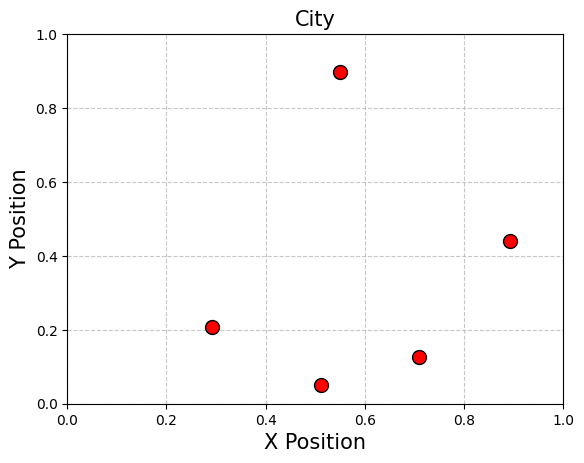

In [3]:
N = 5
np.random.seed(3)

num_qubits = (N - 1)**2

x_pos = np.random.rand(N)
y_pos = np.random.rand(N)

plt.scatter(x_pos, y_pos, c='red', s=100, edgecolors='k', zorder=3)
plt.title(f"City", fontsize=15)
plt.xlabel("X Position", fontsize=15)
plt.ylabel("Y Position", fontsize=15)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)

In [4]:
d = [[0]*N for _ in range(N)]
for i in range(N):
  for j in range(N):
    d[i][j] = np.sqrt((x_pos[i] - x_pos[j])**2 + (y_pos[i] - y_pos[j])**2)

instance_data = {"N": N, "d": d}

num_qubits = (N - 1)**2

# Quantum Approximate Optimization Algorithm (QAOA)
We will solve the TSP using the standard Quantum Approximate Optimization Algorithm (QAOA). An overview of QAOA is provided in another tutorial [1], so please refer to that for more details.

First, we will use the JijModeling-Transpiler to generate an model as intermediate representation from our formulated TSP problem and the instance data.

In [5]:
compiled_instance = jmt.compile_model(problem, instance_data)

Next, we will utilize the `QAOAConverter`. We set the weights for the constraint terms and generate the QAOA circuit and Hamiltonian. In this tutorial, we use $p=2$. However, since the performance of QAOA and the Quantum Alternating Operator Ansatz can vary significantly depending on the value of $p$, interested readers are encouraged to try larger values of $p$ (note that computation time will increase).

In [6]:
p = 4
qaoa_converter = qm.qaoa.QAOAConverter(compiled_instance)
qaoa_converter.ising_encode(multipliers={"Visit all cities at least once": 42, "Visit one city at each time": 42})
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p)
qaoa_cost = qaoa_converter.get_cost_hamiltonian()

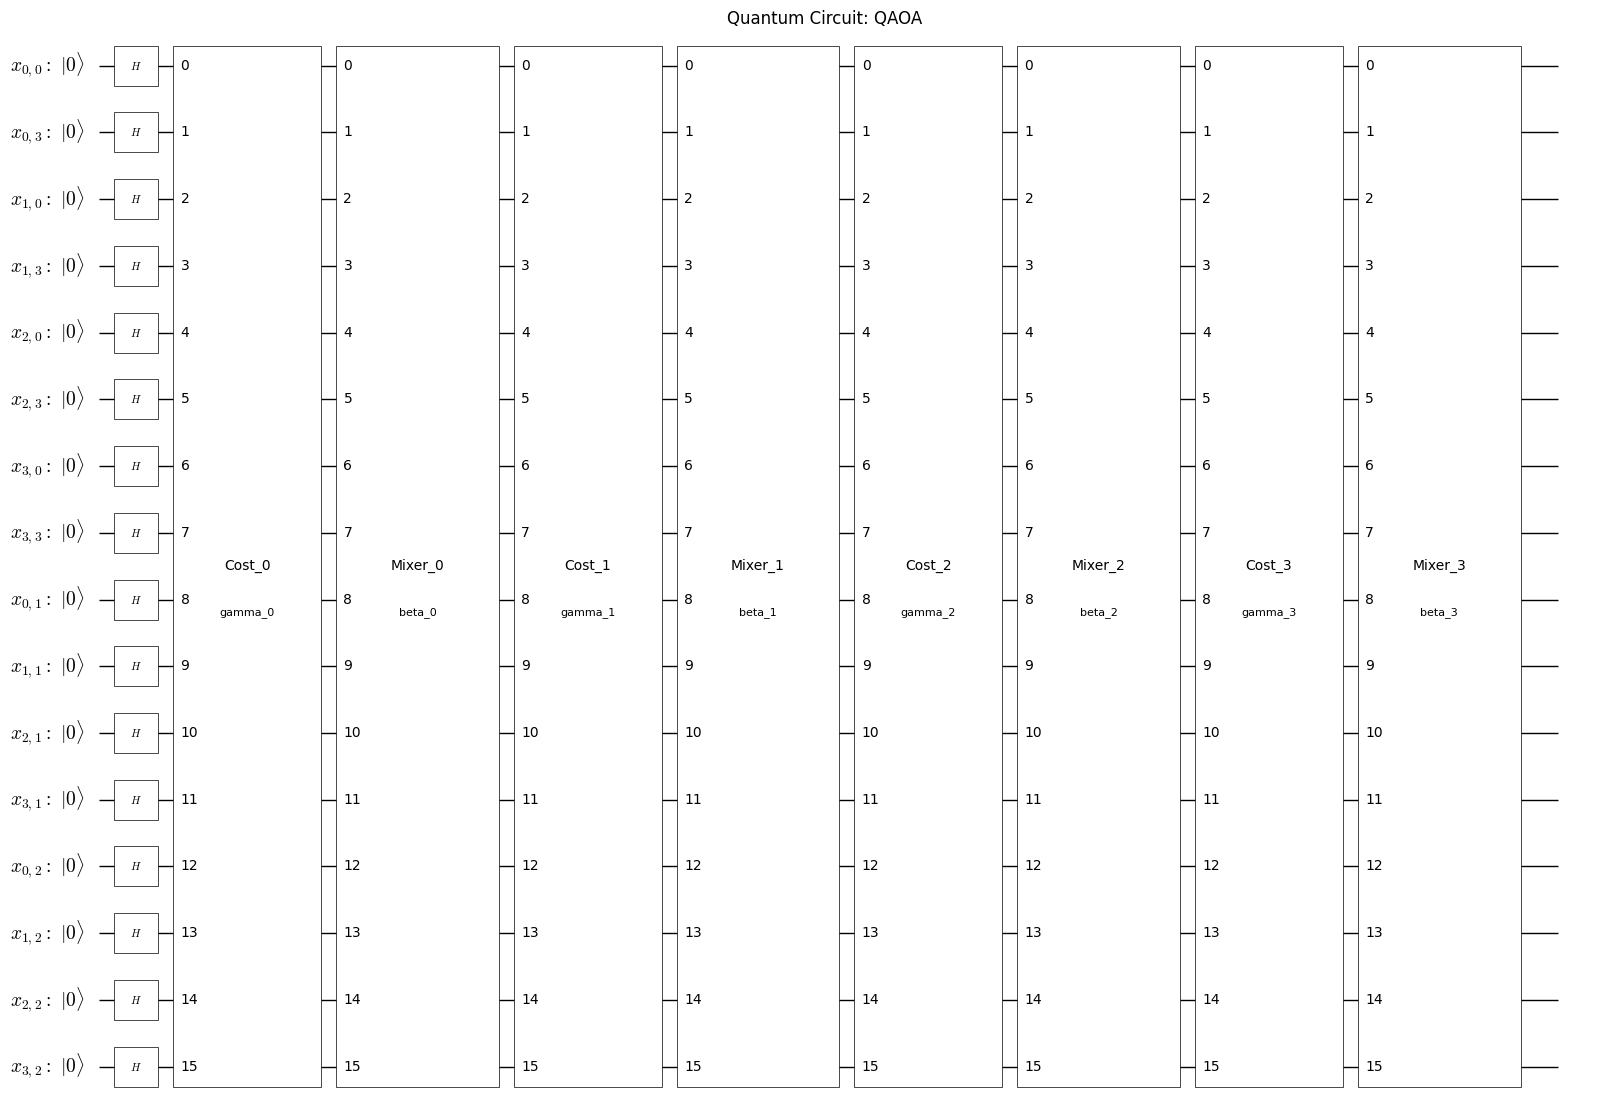

In [7]:
from qamomile.core.circuit.drawer import plot_quantum_circuit

plot_quantum_circuit(qaoa_circuit)

# Executing with Quri-Parts
Next, we will convert the circuit and Hamiltonian generated by Qamomile into objects compatible with Quri-Parts. This will enable us to run the quantum algorithm using Quri-Parts as our simulation framework.

In [8]:
from qamomile.quri_parts import QuriPartsTranspiler

qp_transpiler = QuriPartsTranspiler()
qp_circuit = qp_transpiler.transpile_circuit(qaoa_circuit)
qp_cost = qp_transpiler.transpile_hamiltonian(qaoa_cost)

In [9]:
from quri_parts.core.state import quantum_state, apply_circuit

cb_state = quantum_state(qaoa_circuit.num_qubits, bits=0)
parametric_state = apply_circuit(qp_circuit, cb_state)

In [10]:
from typing import Sequence
from quri_parts.qulacs.estimator import create_qulacs_vector_parametric_estimator
from scipy import optimize as opt

estimator = create_qulacs_vector_parametric_estimator()

cost_history = []
def cost_fn(param_values: Sequence[float]) -> float:
    estimate = estimator(qp_cost, parametric_state, param_values)
    cost = estimate.value.real
    cost_history.append(cost)
    return cost

def create_initial_param(p: int) -> list[float]:
    res = []
    # beta
    for i in range(p):
        res.append(np.pi/(2 * (p - i)))
    # gamma
    for i in range(p):
        res.append(np.pi/(2 * (i + 1)))
    return res


param_result = opt.minimize(cost_fn,create_initial_param(p), method="COBYLA", options={"maxiter": 1000})
param_result

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -16.533742755961427
       x: [ 2.202e-01  6.861e-01  4.927e-01  1.213e+00  2.635e+00
            1.836e-01  1.769e-01 -9.130e-02]
    nfev: 1000
   maxcv: 0.0

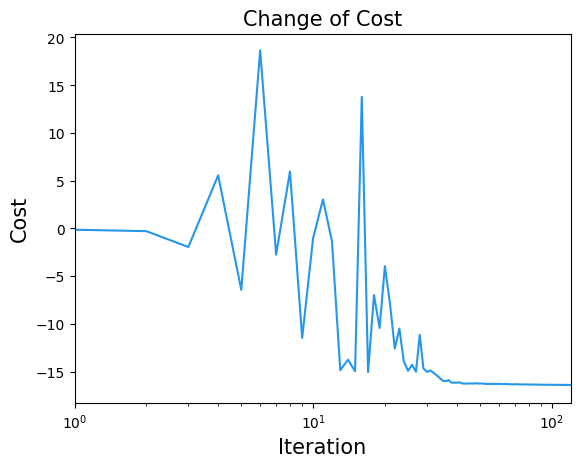

In [11]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, 120)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

In [12]:
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler

sampler = create_qulacs_vector_sampler()
bounded_circuit = qp_circuit.bind_parameters(param_result.x)
qp_result = sampler(bounded_circuit, 10000)

Finally, we convert the sampled results back into solutions for the original Travelling Salesman Problem.

In [13]:
sampleset = qaoa_converter.decode(qp_transpiler, (qp_result, qaoa_circuit.num_qubits))

# Visualizing the Sampled Results
Finally, we display the sampled results using graphs to visualize the solutions obtained from the algorithm. Please note that in some cases, a feasible solution may not be achieved.

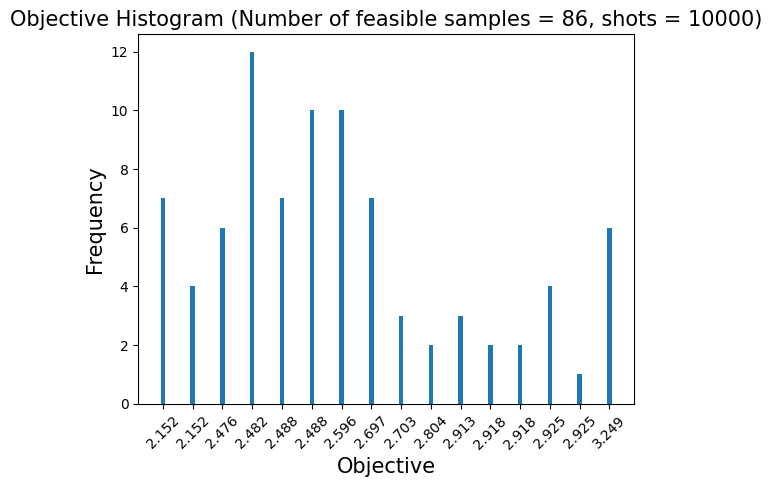

In [14]:
from collections import defaultdict
def show_energy_histogram(sampleset):
    # Create a defaultdict to store the frequency of each energy level
    d = defaultdict(int)
    for sample in sampleset.feasibles():
        d[sample.eval.objective] += sample.num_occurrences

    # Extract energy levels and their corresponding frequencies
    energies = list(d.keys())
    num_occurrences = list(d.values())
    
    # Calculate the total number of shots
    shots = 0
    for sample in sampleset.data:
        shots += sample.num_occurrences

    # Sort energies and corresponding occurrences to ensure proper order
    sorted_pairs = sorted(zip(energies, num_occurrences))
    energies, num_occurrences = zip(*sorted_pairs)
    # Plot the histogram with equally spaced bars
    plt.bar(range(len(energies)), num_occurrences, width=0.15, align='center')
    plt.title("Objective Histogram (Number of feasible samples = {0}, shots = {1})".format(sum(num_occurrences), shots), fontsize=15)
    plt.ylabel("Frequency", fontsize=15)
    plt.xlabel("Objective", fontsize=15)
    plt.xticks(range(len(energies)), np.round(energies,3), rotation=45) 
    plt.show()
    
show_energy_histogram(sampleset)

We got the optimal solution from the sampleset and display the corresponding route.

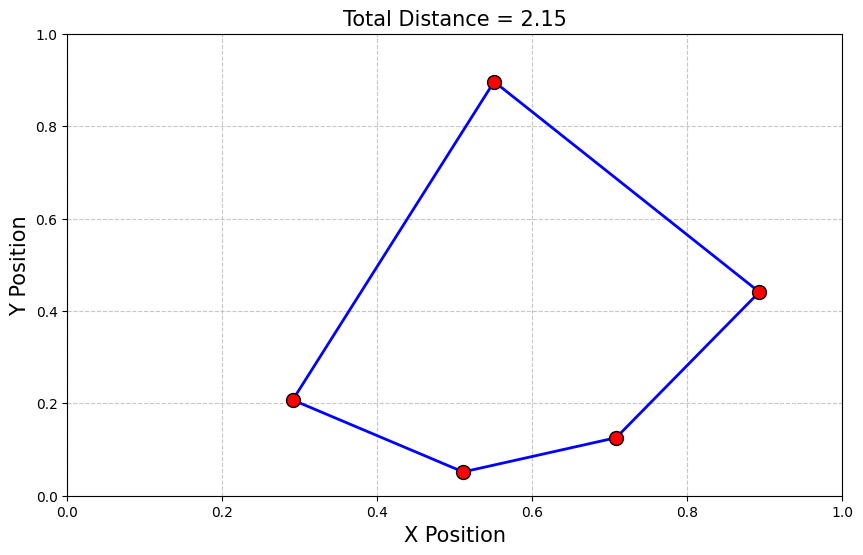

In [15]:
def plot_tsp(sampleset, x_pos, y_pos, N):
    feasible_samples = sampleset.feasibles()
    
    if len(feasible_samples) == 0:
        print("No feasible solution")
    else:
        # Extract the best feasible sample
        best_sample = feasible_samples.lowest()[0]
        d = best_sample.var_values["x"].values
        
        # Determine the route
        route = [N - 1] * (N + 1)
        for key in d.keys():
            route[key[1] + 1] = key[0]
        
        # Calculate the total distance and plot the route
        total_distance = 0
        plt.figure(figsize=(10, 6))
        
        for i in range(len(route) - 1):
            x_coords = [x_pos[route[i]], x_pos[route[i + 1]]]
            y_coords = [y_pos[route[i]], y_pos[route[i + 1]]]
            plt.plot(x_coords, y_coords, 'b-', linewidth=2)
            total_distance += np.sqrt((x_coords[0] - x_coords[1]) ** 2 + (y_coords[0] - y_coords[1]) ** 2)
        
        # Plot the nodes
        plt.scatter(x_pos, y_pos, c='red', s=100, edgecolors='k', zorder=3)
        
        # Set plot properties
        plt.title(f"Total Distance = {total_distance:.2f}", fontsize=15)
        plt.xlabel("X Position", fontsize=15)
        plt.ylabel("Y Position", fontsize=15)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Show the plot
        plt.show()
        
plot_tsp(sampleset, x_pos, y_pos, N)